# Using word embeddings

Another popular and powerful way to associate a vector with a word is the use of dense "word vectors", also called "word embeddings".

One-hot encoding are binary, sparse (mostly made of zeros) and very high-dimensional (same dimensionality as the number of words in the vocabulary).

Word embeddings are low-dimensional floating point vectors (dense vectors). Unlike word vectors obtained via one-hot encoding, word embeddings are learned from data. It is common to see word embeddings that are 256-dimensional, 512-dimensional, or 1024-dimensional when deal with very large vocabularies.

There are two ways to obtain word embeddings:
* Learn word embeddings jointly with the main task you care about.
* Load into your model word embeddings that were pre-computed using a different machine learning task than the one you are trying to solve. These are called "pre-trained word embeddings".

## Learning word embeddings with the <font color="red"> EMBEDDING </font> layer

It is thus reasonable to *learn* a new embedding space with every new task. Thankfully, backpropagation makes this really easy, and Keras makes it even easier. It's just about learning the weights a layer: the <font color="red"> Embedding </font> layer.

In [1]:
from keras.layers import Embedding

# The embedding layer takes at least two arguments:
# the number of possible tokens, here 1000,
# and the dimensionality of the embeddings, here is 64.
embedding_layer = Embedding(1000, 64)

C:\Users\tangxin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


The *Embedding* layer is best understood as a dictionary mapping integer indicies (which stand for specific words) to dense vectors. It takes as input integers, it looks up these integers into an internal dictionary, and it returns the associated vectors. It's effectively a dictionary lookup.

In [7]:
# Listing 6.6 Loading the IMDB data for use with an Embedding layer.
from keras.datasets import imdb
from keras import preprocessing

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words
# (among top max_fratures most common words)
maxlen = 20

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(x_train.shape, y_train.shape)

# This turns out lists of integers
# into a 2D integer tensor of shape '(samples, maxlen)'
x_train_new = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test_new = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)
print(x_train.shape)

(25000,) (25000,)
(25000,)


In [11]:
len(x_train[2])

141

In [12]:
x_train_new

array([[  65,   16,   38, ...,   19,  178,   32],
       [  23,    4, 1690, ...,   16,  145,   95],
       [1352,   13,  191, ...,    7,  129,  113],
       ...,
       [  11, 1818, 7561, ...,    4, 3586,    2],
       [  92,  401,  728, ...,   12,    9,   23],
       [ 764,   40,    4, ...,  204,  131,    9]])

In [15]:
# Listing 6.7 Using an Embedding layer and classifier on the IMDB data.
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen)) # word embedding
# After the Embedding layer,
# our actrivations have shape '(samples, maxlen, 8)'.

# We flatten the 3D tensor of embeddings
# into 2D tensor of shape '(samples, maxlen * 8)'
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train_new, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_3 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 6s 309us/step - loss: 0.6683 - acc: 0.6191 - val_loss: 0.6113 - val_acc: 0.7040
Epoch 2/10
20000/20000 [==============================] - 3s 134us/step - loss: 0.5349 - acc: 0.7539 - val_loss: 0.5196 - val_acc: 0.7334
Epoch 3/10
20000/20000 [==============================] - 3s 128us/step - los

## Using pre-trained word embeddings

Sometimes, you have so little training data available that could never use your data alone to learn an appropriate task-specific embedding of your vocabulary.

Instead of learning word embedding jointly with the problem you want to solve, you could be loading embedding vectors from a pre-computed embedding space known to be highly structured and to exhibit useful properties - that captures generic aspects of language structure.

There are various pre-computed databases of word embeddings that can download and start using in a Keras *Embedding* layer. _Word2Vec_ is one of them. Another popular one is called _"GloVe"_.

### put it all together: from raw text to word embeddings

In [1]:
# Listing 6.8 Processing the labels of the raw IMDB data
import os 

imdb_dir = 'D:/databases/IMDB/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dirname = os.path.join(train_dir, label_type)
    for fname in os.listdir(dirname):
        if fname[-4:] == '.txt':
            with open(os.path.join(dirname, fname), 'r', encoding="utf8") as f:
                content = f.read()
            texts.append(content)
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [2]:
texts[0]

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."

### Tokenize the data

In [27]:
# Listing 6.9 Tokenizing the text of the raw IMDB data
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100 # We will cut reviews after 100 words
training_samples = 5000 # We will be training on 200 samples
validation_samples = 10000
max_words = 10000 # we will only consider the top 10000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
print(len(texts))
sequences = tokenizer.texts_to_sequences(texts)
print(sequences[0])
print(max(max(sequences)))

word_index = tokenizer.word_index
#print(word_index)
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor: ', data.shape)
print('Shape of label tensor: ', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples + validation_samples]
y_val = labels[training_samples:training_samples + validation_samples]

25000
[62, 4, 3, 129, 34, 44, 7576, 1414, 15, 3, 4252, 514, 43, 16, 3, 633, 133, 12, 6, 3, 1301, 459, 4, 1751, 209, 3, 7693, 308, 6, 676, 80, 32, 2137, 1110, 3008, 31, 1, 929, 4, 42, 5120, 469, 9, 2665, 1751, 1, 223, 55, 16, 54, 828, 1318, 847, 228, 9, 40, 96, 122, 1484, 57, 145, 36, 1, 996, 141, 27, 676, 122, 1, 411, 59, 94, 2278, 303, 772, 5, 3, 837, 20, 3, 1755, 646, 42, 125, 71, 22, 235, 101, 16, 46, 49, 624, 31, 702, 84, 702, 378, 3493, 2, 8422, 67, 27, 107, 3348]
9995
Found 88582 unique tokens.
Shape of data tensor:  (25000, 100)
Shape of label tensor:  (25000,)


In [28]:
# listing 6.10 Parsing the GloVe word embeddings file
glove_dir = 'D:/databases/IMDB'

embeddings_index = {}
with open(os.path.join(glove_dir, 'glove.6B.100d.txt'), 'r', encoding="utf8") as f:
    content = f.readlines()
print(len(content))
for line in content:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

    #print('Found %s word vectors.' % len(embeddings_index))

400000


In [29]:
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [30]:
len(embeddings_index['the'])

100

In [31]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    

### Define a model

In [32]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_6 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [33]:
### Load the glove embeddings in the model
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

### Train and evaluate

In [35]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train, 
                   epochs=50,
                   batch_size=32,
                   validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_modell.h5')

Train on 5000 samples, validate on 10000 samples
Epoch 1/50
5000/5000 [==============================] - 2s 344us/step - loss: 0.2165 - acc: 0.9338 - val_loss: 1.1978 - val_acc: 0.5083
Epoch 2/50
5000/5000 [==============================] - 1s 275us/step - loss: 0.1350 - acc: 0.9520 - val_loss: 1.7674 - val_acc: 0.5100
Epoch 3/50
5000/5000 [==============================] - 1s 264us/step - loss: 0.1075 - acc: 0.9700 - val_loss: 1.3818 - val_acc: 0.5027
Epoch 4/50
5000/5000 [==============================] - 1s 274us/step - loss: 0.0846 - acc: 0.9738 - val_loss: 1.3234 - val_acc: 0.5043
Epoch 5/50
5000/5000 [==============================] - 1s 272us/step - loss: 0.0488 - acc: 0.9854 - val_loss: 1.5240 - val_acc: 0.5078
Epoch 6/50
5000/5000 [==============================] - 1s 268us/step - loss: 0.0543 - acc: 0.9846 - val_loss: 2.6175 - val_acc: 0.5050
Epoch 7/50
5000/5000 [==============================] - 1s 263us/step - loss: 0.0482 - acc: 0.9882 - val_loss: 1.7507 - val_acc: 0.5058

### Plotting results

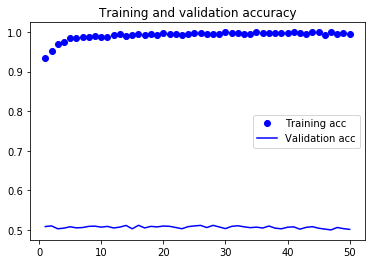

In [36]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()


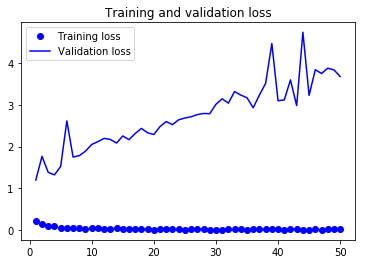

In [37]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
             epochs=60,
             batch_size=32,
             validation_data=(x_val, y_val))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_8 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 5000 samples, validate on 10000 samples
Epoch 1/60
5000/5000 [==============================] - 2s 377us/step - loss: 0.6945 - acc: 0.4914 - val_loss: 0.6935 - val_acc: 0.4921
Epoch 2/60
5000/5000 [==============================] - 2s 309us/step - loss: 0

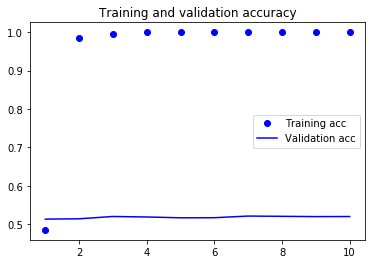

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

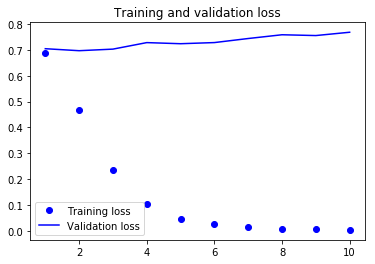

In [26]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()